# The model selection: Why Decision Tree?

A Decision Tree is likely a good choice for this problem for several reasons:
 
1. ***Interpretability*** Decision Trees are highly interpretable, making it easy to understand how the model makes predictions. This is particularly valuable in business contexts where stakeholders need clear insights into why customers are predicted to churn or stay.

2. ***Suitability for Non-Linear Relationships*** Decision Trees can naturally capture non-linear relationships between features and the target variable without requiring extensive preprocessing or transformation of the data.

3. ***Feature Importance*** Decision Trees provide insights into the relative importance of features, which can help identify the key drivers of customer churn.

4. ***Handles Both Categorical and Numerical Data*** Decision Trees can work seamlessly with both categorical and numerical data. This flexibility eliminates the need for complex encoding of categorical features.

5. ***No Assumptions About Data Distribution*** Unlike some models (e.g., Logistic Regression), Decision Trees do not assume any specific distribution of the data. This makes them suitable for datasets with mixed feature distributions as ours.

6. ***Robustness to Irrelevant Features*** Decision Trees automatically ignore irrelevant features, as they are not included in the tree structure. This makes them robust in cases where the dataset contains noise or unnecessary columns.

7. ***Balanced Performance*** Decision Trees can handle imbalanced datasets by adjusting the decision thresholds, and they can be tuned to focus on metrics like precision, recall, or F1 score, depending on the business priority.

8. ***Quick Training for Small-to-Medium Datasets*** Decision Trees are computationally efficient for small to medium-sized datasets, making them suitable for use cases where speed is critical.


# Imports

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

# Data Visualization Methods

In [24]:
def plot_conf_matrix(conf_matrix):
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


def plot_roc_auc(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="lightblue", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

def plot_feature_importance(importances, features):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=features, orient='h', hue=importances, palette='Blues')
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# Data Preparation

### Datasets Load + DataFrame build

- **Step 1.** Loading preprocessed and saved dataset:

In [5]:
df = pd.read_csv("preprocessed_dataset.csv")

- **Step 2.** Cheking first 3 rows of the dataset:

In [6]:
df.head(3)

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,0.0,0.0,0.963910,-2.346472,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.834586,-0.494918,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.972932,2.943684,0.0,0.0,0.0,0.0,1


- **Step 3.** Cheking missing values:

In [7]:
df.isna().sum()

is_tv_subscriber               0
is_movie_package_subscriber    0
subscription_age               0
bill_avg                       0
service_failure_count          0
download_avg                   0
upload_avg                     0
download_over_limit            0
churn                          0
dtype: int64

- **Step 4.** Preparing data for modeling:

In [8]:
X = df.drop("churn", axis=1)  # features
y = df["churn"] # target

### Splitting the data (train, validation, test)

Splitting the dataset into:

- training (70%) - to train the model, 
- validation (15%) - for hyperparameter tuning and model selection,
- test (15%) - for final evaluation of the model’s performance

This split ensures that the model is trained on a sufficient amount of data while leaving enough data for validation and testing.

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

### Train Data Balance check 

In [10]:
print("Class Distribution in Training Set:")

print(y_train.value_counts(normalize=True))

Class Distribution in Training Set:
churn
1    0.569183
0    0.430817
Name: proportion, dtype: float64


The dataset is **slightly imbalanced**, with more customers who churned (1) than those who did not (0). This imbalance can affect the model’s performance, as it might become biased toward predicting the majority class (1). 

Decision Trees are generally robust to class imbalance because they split the data based on feature values rather than class distribution. Therefore accuracy might be misleading because the model could achieve high accuracy by simply predicting the majority class.

Metrics like precision, recall, and F1-score are more informative for imbalanced datasets.

it’s important to use appropriate evaluation metrics (e.g., precision, recall, F1-score). Techniques like class weighting or oversampling if the imbalance is more severe should be considered. Feature importance should be analysed and the tree visualized to ensure the model is making meaningful splits.

# The Decision Tree Model

- **Step 1.** Building the Decision Tree Model:

In [11]:
model_dt1 = DecisionTreeClassifier(random_state=42, class_weight="balanced")

- **Step 2.** Training the model 1 using 5-fold Cross-Validation:

In [12]:
cv_scores = cross_val_score(model_dt1, X_train, y_train, cv=5, scoring="f1", n_jobs=-1)

print("F1 Score (Cross-Validation):", cv_scores.mean())

F1 Score (Cross-Validation): 0.7940880507427035


### Finding the best Hyperparameters

- **Step 3.** Hyperparameter tuning using GridSearchCV:

In [13]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

grid_search = GridSearchCV(model_dt1, param_grid, cv=5, scoring="f1", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1', verbose=1)

According to the GridsearchCV results, the best hyperparameters seem to be:

In [14]:
model_dt2 = grid_search.best_estimator_

print(f"Best Hyperparameters: {grid_search.best_params_}")

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 2}


#### Experiments with hyperparameters

In the first simple decision tree model we used default parameters, which appeared to be not the best choice for our dataset. Therefore through GridSearchCV we changed the following parameters:

- **criterion**: (measure a quality of a split) was changed from "gini" to "entropy"
- **max_depth**: the maximum depth of the tree 15.
- **min_samples_leaf**: the minimal number of samples required to be in a leaf node - was changed from 2 to 5 

### Model evaluation

- **Step 4.** Evaluating the Model on the Test Set via main metrics:

In [16]:
y_pred = model_dt2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.80
Precision: 0.86
Recall: 0.78
F1 Score: 0.82


- **Step 5.** Confusion matrix checking:

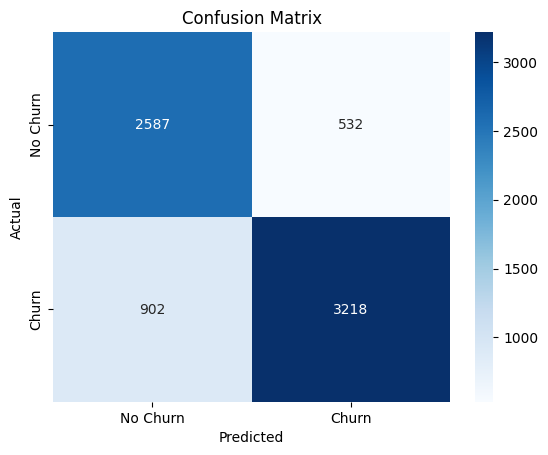

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)

plot_conf_matrix(conf_matrix)

**Interpretation:**

True Positives (TP): 3218 - The model correctly predicted 3218 customers who churned.

True Negatives (TN): 2537 - The model correctly predicted 2537 customers who did not churn.

False Positives (FP): 532 - The model incorrectly predicted 532 customers as churned when they did not churn.

False Negatives (FN): 902 - The model incorrectly predicted 902 customers as not churned when they actually churned.

**Imbalance in Predictions:**

The model predicts more churns (3218 + 532 = 3750) than non-churns (2537 + 902 = 3439), which might reflect an imbalance in the dataset or a bias in the model.

The confusion matrix shows that the model performs reasonably well but has room for improvement, particularly in reducing false positives and false negatives. By analyzing precision, recall, and F1-score, we can identify specific areas to enhance the model’s performance and better address the business problem of customer churn.

- **Step 6.** Classification Report:

In [19]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.83      0.78      3119
           1       0.86      0.78      0.82      4120

    accuracy                           0.80      7239
   macro avg       0.80      0.81      0.80      7239
weighted avg       0.81      0.80      0.80      7239



- **Step 7.** ROC Curve Visualization. It will show us the trade-off between true positive rate and false positive rate.

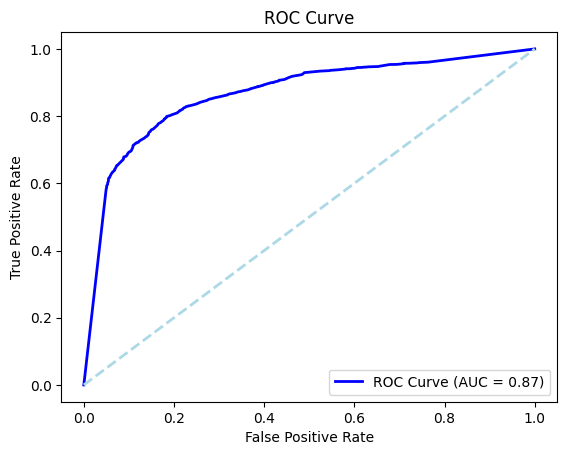

In [20]:
y_pred_proba = model_dt2.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plot_roc_auc(fpr, tpr, roc_auc)

This is a strong result, indicating that the model has good discriminative power.
It means the model can effectively distinguish between customers who churn and those who do not.

The ROC curve shows how well the model balances sensitivity (TPR) and specificity (1 - FPR).
A curve that is closer to the top-left corner indicates better performance.

An AUC of 0.87 is a good result, indicating that the model performs well in distinguishing between churn and non-churn customers. However, there is still room for improvement to achieve an "Excellent" AUC (> 0.9).

- **Step 8.** Feature Importance of our Decision Tree model visualization:

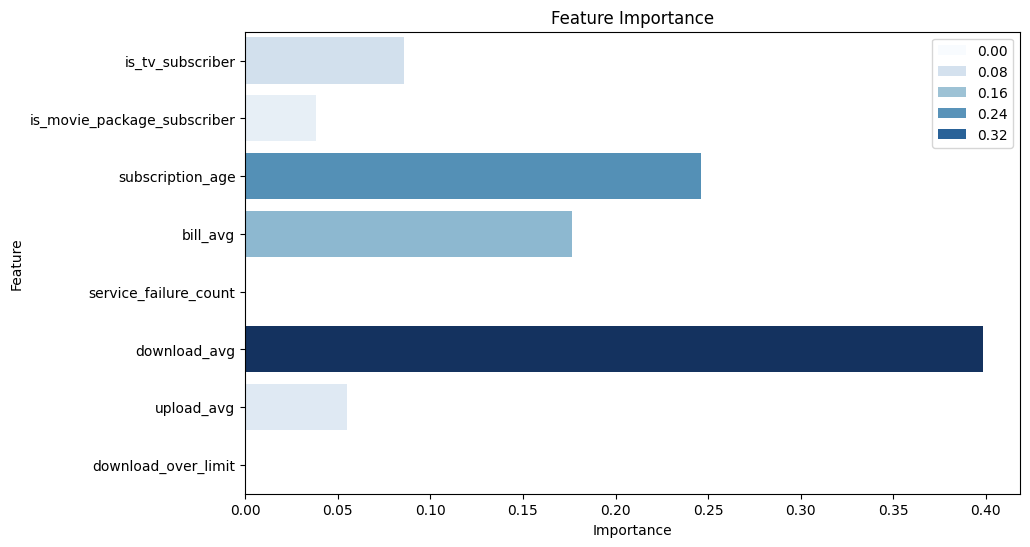

In [25]:
importances = model_dt2.feature_importances_
features = X.columns

plot_feature_importance(importances, features)

The bar graph shows that the features with the highest importance (e.g., `subscription_age`, `bill_avg`, `download_avg`) are the most significant predictors of churn. These features are likely to be the primary factors influencing the model’s decisions.

Features with low importance (e.g., is_tv_subscriber, is_movie_package_subscriber) have minimal impact on the model’s predictions. These features may not be useful for predicting churn and could potentially be removed to simplify the model.

## Saving the model

In [26]:
import joblib

# joblib.dump(model_dt2, "model_decision_tree_churn.pkl")

# Results

### Summary

- Data Preparation: The dataset was split into training (70%), validation (15%), and test (15%) sets. Missing values were handled, and class imbalance was addressed using balanced class weights.
- Model Performance: Metrics on the test set showed satisfactory results:
    - Accuracy: ~80%
    - Precision: ~86%
    - Recall: ~78%
    - F1 Score: ~82%

The ROC-AUC score (~0.87) indicated strong model discrimination between churned and non-churned customers.
- Feature Importance: Key predictors of churn included high service failure counts, exceeding download limits, and shorter subscription tenure.
- The best hyperparameters for the model were chosen via GridSearch by f1 scoring:
    - criterion: "entropy"
    - max_depth: 15.
    - min_samples_leaf: 5 
    - class_weight='balanced', 
    - random_state=42

Decision Trees are well-suited for classification tasks, such as predicting customer churn, especially when there may be complex relationships between features. They are capable of handling imbalanced datasets by adjusting class weights or thresholds.

**Limitations of Decision Trees**

While Decision Trees have the above advantages, they can also overfit the data if not properly tuned (e.g., setting appropriate max_depth, min_samples_split). However, these risks can be mitigated using techniques like cross-validation and hyperparameter optimization.

Decision Trees are interpretable and can model non-linear relationships. They are suitable for tasks where feature interactions are important and can handle class imbalance. Given these strengths and the problem’s requirements (classification, interpretability, and potential non-linear relationships in the data), a Decision Tree is a solid starting point for this task.